<a href="https://colab.research.google.com/github/vaishnavisharma6/MLP-indicator/blob/main/MLP_Indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP as a troubled cell indicator (Code structure)

Steps involved:
1. Choose a function whose regularity is known in chosen domain, e.g. sin function.

2. Pick a point $x_{i}$ ∈[a,b] such that a  ≤ $x_{i} -\frac{3}{2}h$  ≤ $x_{i} + \frac{3}{2}h$ ≤ b and then construct a 3-cell stencil centered at $x_{i}$.

3. In each cell, project the solution onto the space of polynomials of degree r. (Lagrange polynomial).

4. Find cell-averages of the approximating polynomials in each of three cells to obtain values $\bar{u}_{i-1}$, $\bar{u}_{i}$, and $\bar{u}_{i+1}$. Also find out $u^{+}_{i-\frac{1}{2}}$ and $u^{-}_{i+\frac{1}{2}}$ (cell interface values). These five quantitites constitute our input vector **X** for cell $I_{i}$.

5.True output corresponding to **X** depends on the regularity of solution in stencil. If solution loses dicontinuity then output vector should be $Y = (1,0)^{T}$, otherwise it should be $Y = (0,1)^{T}$.

In [41]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import LeakyReLU
from sklearn.utils import shuffle
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import io
%config InlineBackend.figure_format = 'svg'



## 2. Generate input vectors and output vectors

In [42]:
url1 = 'https://github.com/vaishnavisharma6/MLP-indicator/raw/main/all_data_train.txt'
url2 = 'https://github.com/vaishnavisharma6/MLP-indicator/raw/main/all_data_val.txt'

df1 = pd.read_csv(url1, sep = ' ')
df2 = pd.read_csv(url2, sep = ' ')

print(df1)

       -1.000000000000000000e+00  -5.829503307013169655e-01  \
0                      -0.058201                  -0.058201   
1                      -0.484095                   0.634309   
2                       0.740388                  -0.187291   
3                       0.014946                   0.268810   
4                       0.501169                  -0.432314   
...                          ...                        ...   
23994                  -0.933028                  -0.933028   
23995                  -0.053794                   0.310839   
23996                  -0.876318                  -0.876318   
23997                  -1.000000                  -0.383426   
23998                  -0.100231                  -0.533527   

       -1.659006614026339865e-01  -7.914751653506579832e-01  \
0                      -0.058201                  -0.058201   
1                       0.277127                   0.268617   
2                      -0.589194                   0.6

## 3. Training script

In [49]:
nt = df1.shape[0]
nv= df2.shape[0]
data1 = df1.to_numpy()
data2 = df2.to_numpy()
xt = data1[:,0:5]
yt = data1[:,5]
xv = data2[:,0:5]
yv = data2[:,5]

In [55]:
class Trainingplot(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs = {}):
    self.losses = []
    self.val_losses = []
    self.logs = []
  def on_epoch_end(self, epoch, logs = {}):
    self.logs.append(logs)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))  

    if epoch >1 and epoch%500 == 0:                                                             #callback function
       clear_output(wait = True)
       N = np.arange(0, len(self.losses))  

       plt.figure()
       plt.semilogy(N, self.losses, label = 'Train_loss')
       plt.semilogy(N, self.val_losses, label = 'Validation loss')
       plt.title('After epoch = {}'.format(epoch))
       plt.xlabel('Epoch #')
       plt.ylabel('Loss')
       plt.legend()
       plt.show()

In [56]:
# model architecture
def NN(para):
  opt = para[0]
  lrate = para[1]
  actf = para[2]
  actp = para[3]
  cost = para[4]
  reg = para[5]
  regp = para[6]
  
  if actf == 'lReLU':
    actf = keras.layers.LeakyReLU(v)
  else:  
    actf = keras.layers.elu(v)

  if reg == 'l1':
    reg = keras.regularizers.l1(regp)
  else:
    reg = keras.regularizers.l2(regp)  
  
  if cost == 'cross entropy':
    cost = keras.losses.BinaryCrossentropy()

  model = Sequential()

  model.add(Dense(256, input_shape = (5,), activation = actf, kernel_regularizer = reg))
  model.add(Dense(128, activation = actf, kernel_regularizer = reg))
  model.add(Dense(64, activation = actf, kernel_regularizer = reg))
  model.add(Dense(32, activation = actf, kernel_regularizer = reg))
  model.add(Dense(16, activation = actf, kernel_regularizer = reg))
  model.add(Dense(1, activation = 'softmax'))

  model.compile(optimizer = opt, loss = cost, metrics = ['accuracy'])
  
  
  return model

In [57]:
# function call

opt = 'adam'
n = 1e-3                 # learning rate
A = 'lReLU'              # activation function
v = 1.0e-3               # activation parameter
C = 'cross entropy'      # cost function
reg = ['l1', 'l2']       # regularizer
b = 1.0e-5               # regularization parameter
N = 5000                 # maximum number of epochs
Sb = 512                 # mini batch size
R = 3                    # Number of restarts

para = list((opt, n, A, v, C, reg, b))
print(para)
model = NN(para)

['adam', 0.001, 'lReLU', 0.001, 'cross entropy', ['l1', 'l2'], 1e-05]


In [58]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               1536      
                                                                 
 dense_49 (Dense)            (None, 128)               32896     
                                                                 
 dense_50 (Dense)            (None, 64)                8256      
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 dense_52 (Dense)            (None, 16)                528       
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 45,313
Trainable params: 45,313
Non-trai

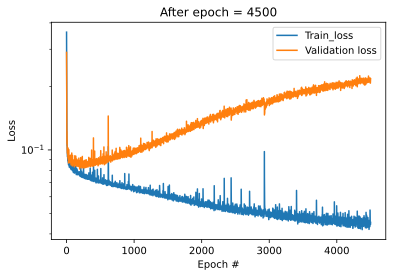

In [59]:
plot_losses = Trainingplot()
model.fit(xt, yt, batch_size = Sb, epochs = N, verbose = 0, validation_data = (xv, yv), shuffle = True, callbacks = [plot_losses])


In [65]:
? model.evaluate

In [66]:
train_loss, train_acc = model.evaluate(xt, yt)
print(model.evaluate(xt,yt))
print('Train accuracy:', train_acc)
valid_loss, valid_acc = model.evaluate(xv, yv)
print(model.evaluate(xv,yv))
print('Validation accuracy:', valid_acc)


750/750 [==============================] - 2s 2ms/step - loss: 0.0405 - accuracy: 0.9187
[0.04051297530531883, 0.9186632633209229]
Train accuracy: 0.9186632633209229
750/750 [==============================] - 2s 2ms/step - loss: 0.2234 - accuracy: 0.9162
[0.22337765991687775, 0.9162465333938599]
Validation accuracy: 0.9162465333938599
